In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools
from localcider.sequenceParameters import SequenceParameters
import mdtraj as md
import os
import multiprocessing as mp
import wget
import matplotlib.patheffects as PathEffects
from scipy.optimize import least_squares
from scipy.stats import gaussian_kde

In [3]:
def get_kappa(seq):
    SeqObj = SequenceParameters(seq)
    return SeqObj.get_kappa()

def nmc_charge(seqs):
    nmc = np.full((len(seqs),3),0)
    for i,s in enumerate(seqs):
        l = int(len(s)/3)
        sc = np.array([aa_params.loc[aa].q for aa in s])
        n = sc[:l].sum()
        m = sc[l:2*l].sum()
        c = sc[-l:].sum()
        nmc[i] = np.array([n,m,c])
    return nmc

def seq_diagram(seq,ax,lw=2.3):
    lamb = [aa_params.loc[aa].M1 for aa in seq]
    charge = [aa_params.loc[aa].q for aa in seq]
    for i,l in enumerate(lamb):
        ax.set_xlim(0,len(lamb)+1)
        ax.set_ylim(0,1)
        ax.set_yticks([])
        ax.set_xticks([])
        if charge[i] == 0:  
            ax.vlines(i+1, 0,1, color=str((l*(-1))+1),alpha=0.7,lw=lw)
        if charge[i] == -1:
            ax.vlines(i+1, 0,1, color='tab:red',lw=lw)
        if charge[i] == 1:
            ax.vlines(i+1, 0,1, color='tab:blue',lw=lw)
    ax.set_xticks([1,len(lamb)])
    ax.set_xlabel('Residue', labelpad=-10)
    
def Csat(data, fasta, L, nskip=1200):
    N = len(fasta)
    h = np.load(data)
    conv = 100/6.022/N/L/L*1e3
    h = h[nskip:]*conv 
    lz = h.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
    
    cutoffs1 = [res1.x[2]-.5*res1.x[3],-res2.x[2]+.5*res2.x[3]]
    cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]
    
    bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1])
    bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1])

    dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
    denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)

    dil = hm[bool2].mean()
    den = hm[bool1].mean()
    
    av, sem, _ = autoblock(dilarray)

    return av*1000, sem*1000, cutoffs1, cutoffs2

def autoblock(x):
    block = BlockAnalysis(x)
    #plt.errorbar(block.stat[...,0], block.stat[...,1], block.stat[...,2],'k')
    block.SEM()
    #plt.scatter(block.bs, block.sem)
    #plt.show()
    return block.x.mean(), block.sem, block.bs

def plot_cmap(dat,pairs,ax,vmin,vmax=None):
    cmap = np.full((135,135),1.0)
    for p,v in zip(pairs,dat):
        cmap[int(p[0]),int(p[1])] = v
        cmap[int(p[1]),int(p[0])] = v
    if vmax is None:
        vmax = np.max(cmap)
    im = ax.imshow(cmap,cmap=plt.cm.bone_r,origin='lower',aspect='equal',vmin=vmin,vmax=vmax)
    ax.set_ylabel('Residue')
    ax.set_xlabel('Residue')
    
    return im

In [4]:
aa_params = pd.read_csv('/Users/manuelfernandezlemos/Desktop/_2023_Pesce_IDPdesign/CODE/residues.csv')
aa_params = aa_params.set_index('one')

#_ = wget.download('https://github.com/KULL-Centre/_2023_Tesei_IDRome/raw/main/IDRome_DB.csv')
idrome = pd.read_csv('/Users/manuelfernandezlemos/Desktop/_2023_Pesce_IDPdesign/CODE/IDRome_NARDINI_025_1e5.csv').set_index('seq_name')

idps = ('aSyn','A1','LAF1','FUS','HSFX4','FRAT2','SFMBT1')
labels = (r'$\alpha$Syn','A1-LCD','LAF-1-RGG','FUS-PLD','HSFX4','FRAT2','SFMBT1')

### Figure 2

In [ ]:
down = {
    'A1' : pd.read_pickle('EVOLUTION_DATA/rg_down_A1_rep0-9.pkl'),
    'aSyn' : pd.read_pickle('EVOLUTION_DATA/rg_down_asyn.pkl'),
    'LAF1' : pd.read_pickle('EVOLUTION_DATA/rg_down_laf1.pkl'),
    'FUS' : pd.read_pickle('EVOLUTION_DATA/rg_down_fus.pkl')
}

up = {
    'A1' : pd.read_pickle('EVOLUTION_DATA/rg_up_A1.pkl'),
    'aSyn' : pd.read_pickle('EVOLUTION_DATA/rg_up_asyn.pkl'),
    'LAF1' : pd.read_pickle('EVOLUTION_DATA/rg_up_laf1.pkl'),
    'FUS' : pd.read_pickle('EVOLUTION_DATA/rg_up_fus.pkl')
}


dict_keys(['A1', 'aSyn', 'LAF1', 'FUS'])

/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/2810073531.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes=[down[p].fasta[0].count('R')+down[p].fasta[0].count('K'),
/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/2810073531.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down[p].fasta[0].count('D')+down[p].fasta[0].count('E'),
/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/2810073531.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

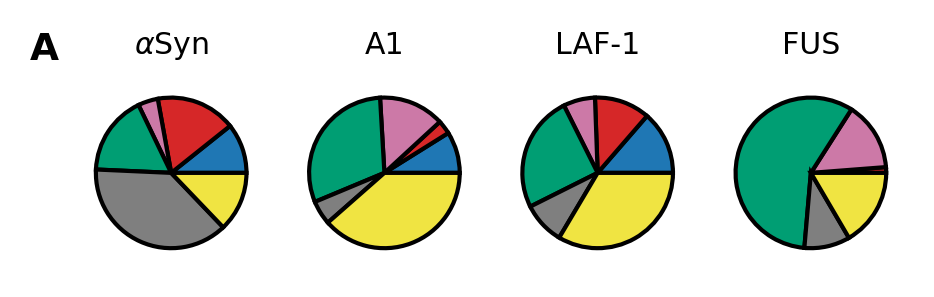

In [17]:
font = {'size': 6}
plt.rc('font', **font)
fig, axs = plt.subplots(1,4, figsize=(3,5), dpi=300, layout='constrained')
axs = axs.flatten()

colors=['tab:blue','tab:red','#CC79A7','#009E73','tab:grey','#F0E442']

for i,p in enumerate(['aSyn','A1','LAF1','FUS']):
    sizes=[down[p].fasta[0].count('R')+down[p].fasta[0].count('K'),
           down[p].fasta[0].count('D')+down[p].fasta[0].count('E'),
           down[p].fasta[0].count('Y')+down[p].fasta[0].count('W')+down[p].fasta[0].count('F'),
           down[p].fasta[0].count('S')+down[p].fasta[0].count('T')+down[p].fasta[0].count('N')+down[p].fasta[0].count('Q')+down[p].fasta[0].count('H')+down[p].fasta[0].count('C'),
           down[p].fasta[0].count('A')+down[p].fasta[0].count('V')+down[p].fasta[0].count('I')+down[p].fasta[0].count('L')+down[p].fasta[0].count('M')+down[p].fasta[0].count('P'),
           down[p].fasta[0].count('G')]
    axs[i].pie(sizes,colors=colors,wedgeprops = {"edgecolor" : "k",
                      'linewidth': 1,
                      'antialiased': True})

axs[0].set_title(r'$\alpha$Syn')
axs[1].set_title(r'A1')
axs[2].set_title(r'LAF-1')
axs[3].set_title(r'FUS')

axs[0].text(-0.25,1.1, 'A', fontsize=9, weight='bold', transform=axs[0].transAxes)

plt.savefig('fig2a.pdf', dpi=300)

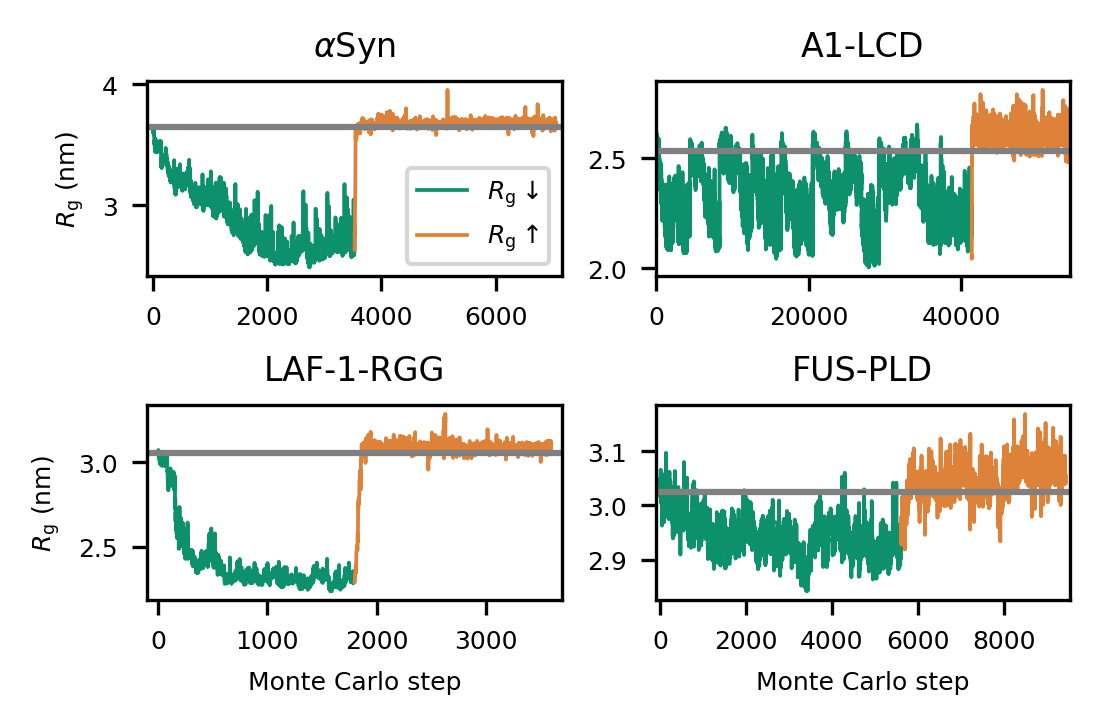

In [18]:
font = {'size': 6}
plt.rc('font', **font)
fig, axs = plt.subplots(2,2, figsize=(3.55,2.3), dpi=300, layout='constrained')
axs = axs.flatten()

for i,p in enumerate(['aSyn','A1','LAF1','FUS']):
    d = down[p].obs.values
    u = up[p].obs.values[:len(d)]
    axs[i].plot(d, label=r'$R_{\rm g} \downarrow$', color='#0D916D', lw=.9)
    axs[i].plot(np.arange(len(d)+1,len(d)+len(u)+1), u, label=r'$R_{\rm g} \uparrow$', color='#DE8239', lw=.9)
    axs[i].hlines(down[p].obs.values[0],-100,len(d)+len(u)+100,color='0.5')
    axs[i].set_xlim(-100,len(d)+len(u)+100)
    axs[i].set_title(labels[i],fontsize=8)

axs[0].set_ylabel(r'$R_{\rm g}$ (nm)')
axs[2].set_ylabel(r'$R_{\rm g}$ (nm)')
axs[2].set_xlabel(r'Monte Carlo step')
axs[3].set_xlabel(r'Monte Carlo step')

axs[0].legend(fontsize=6)
plt.savefig('fig2b.pdf', dpi=300)

### Figure 3

In [ ]:
# k_down = {}
# for p in down.keys()[:-1]:
#     k_down[p] = []
#     for s in down[p].fasta:
#         k_down[p].append(get_kappa(''.join(s)))


# k_down = {k: df['kappa'].to_numpy() for k, df in down.items()}
# k_up   = {k: df['kappa'].to_numpy() for k, df in up.items()}

# down['aSyn']['kappa']
# down['A1']['kappa']
# down['LAF1']['kappa']

from itertools import islice

k_down = {k: df['kappa'].to_numpy()
          for k, df in islice(down.items(), 3)}




In [74]:
# nmc = {}
# for p in down.keys()[:-1]:
#     nmc[p] =  nmc_charge(down[p].fasta.values)

# nmc = {p: nmc_charge(df['fasta'].to_numpy())
#        for p, df in up.items() if p != 'FUS'}


import pandas as pd
from itertools import islice

def _seq_series(col):
    # cells are lists like ['M','D',...] → strings
    try:
        return col.str.join('')
    except Exception:
        return col.apply(lambda s: s if isinstance(s, str) else ''.join(s))

def build_nmc_all_rows(down_dict, keys=None):
    if keys is None:                        # first three keys (skip FUS)
        keys = [k for k, _ in islice(down_dict.items(), 3)]
    out = {}
    for k in keys:
        df = down_dict[k]                   # NO filtering by 'mc' or 'simulate'
        seqs = _seq_series(df['fasta'])
        codes, uniques = pd.factorize(seqs, sort=False)
        charges_unique = nmc_charge(list(uniques))  # compute once per unique seq
        out[k] = charges_unique[codes]      # shape (N, 3)
    return out

# build like the paper
nmc = build_nmc_all_rows(down)

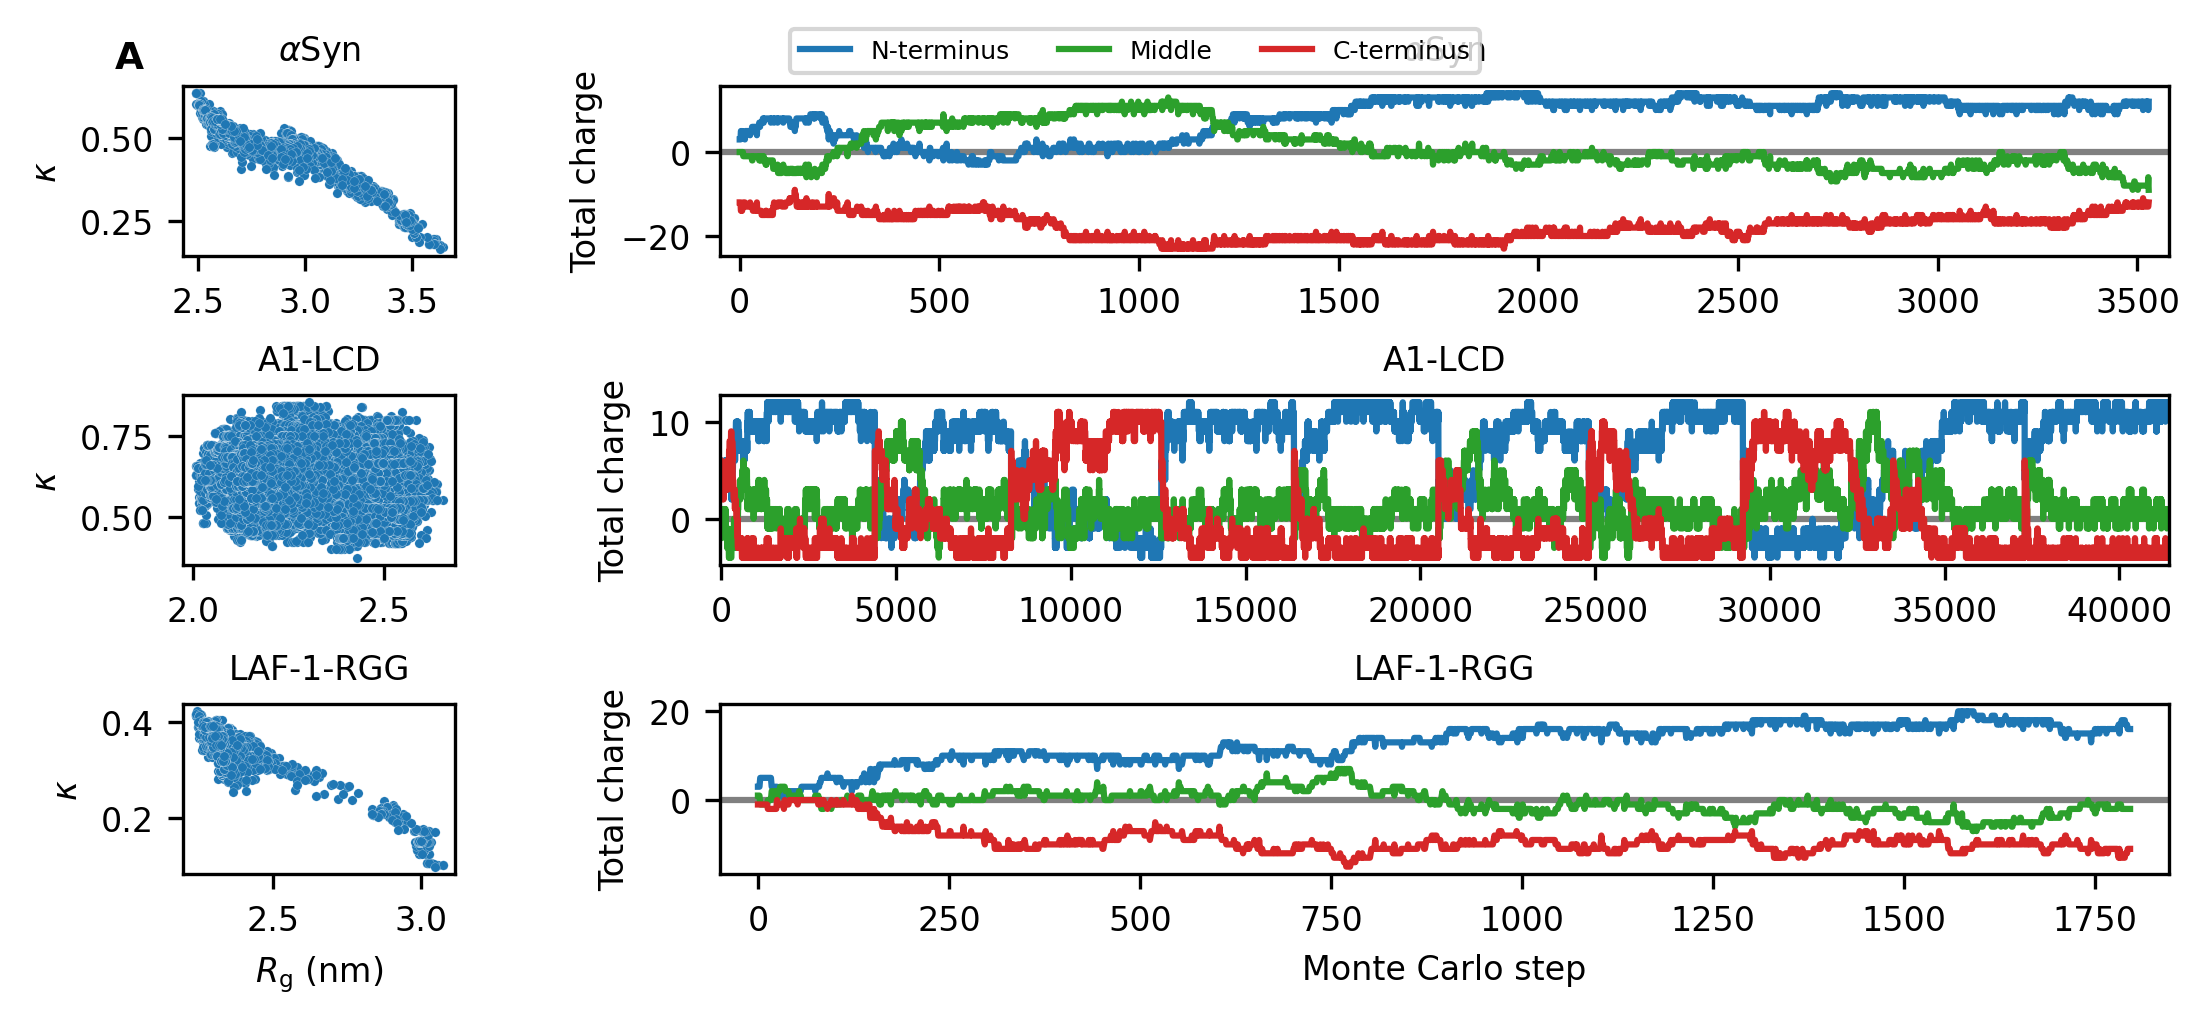

In [75]:
font = {'size': 8}
plt.rc('font', **font)
fig = plt.figure(figsize=(7.25,3.3), dpi=300, layout='constrained')
gs = GridSpec(nrows=3, ncols=20, figure=fig)

ax1 = fig.add_subplot(gs[0:1, 0:3])
ax2 = fig.add_subplot(gs[1:2, 0:3])
ax3 = fig.add_subplot(gs[2:3, 0:3])
ax4 = fig.add_subplot(gs[0:1, 4:20])
ax5 = fig.add_subplot(gs[1:2, 4:20])
ax6 = fig.add_subplot(gs[2:3, 4:20])

#ax1.plot([1, 0], [0, 1], transform=ax1.transAxes,c='0.7')
ax1.scatter(down['aSyn'].obs.values, k_down['aSyn'], edgecolors='w', linewidths=0.05, s=5)
ax1.set_ylabel(r'$\kappa$')
#ax1.set_xlabel(r'$R_{\rm g}$ (nm)')
ax1.set_title(r'$\alpha$Syn', fontsize=8)
ax1.text(-0.25,1.1, 'A', fontsize=9, weight='bold', transform=ax1.transAxes)

#ax2.plot([1, 0], [0, 1], transform=ax2.transAxes,c='0.7')
ax2.scatter(down['A1'].obs.values, k_down['A1'], edgecolors='w', linewidths=0.05, s=5)
#ax2.set_xlabel(r'$R_{\rm g}$ (nm)')
ax2.set_title(r'A1-LCD', fontsize=8)
ax2.set_ylabel(r'$\kappa$')

#ax3.plot([1, 0], [0, 1], transform=ax3.transAxes,c='0.7')
ax3.scatter(down['LAF1'].obs.values, k_down['LAF1'], edgecolors='w', linewidths=0.05, s=5)
ax3.set_xlabel(r'$R_{\rm g}$ (nm)')
ax3.set_title('LAF-1-RGG', fontsize=8)
ax3.set_ylabel(r'$\kappa$')

ax4.hlines(0,-50,len(down['aSyn'].index)+50,color='0.5')
ax4.set_xlim(-50,len(down['aSyn'].index)+50)
ax4.set_title(r'$\alpha$Syn', fontsize=8)
ax4.plot(nmc['aSyn'][...,0], label='N-terminus')
ax4.plot(nmc['aSyn'][...,1], label='Middle', color='tab:green')
ax4.plot(nmc['aSyn'][...,2], label='C-terminus', color='tab:red')
ax4.legend(ncol=3, fontsize=6, bbox_to_anchor=(0.04,1,0,0))
ax4.set_ylabel('Total charge')
#ax1.text(-0.25,-0.65, 'b', fontsize=15, weight='bold', transform=ax1.transAxes)

ax5.hlines(0,-50,len(down['A1'].index)+50,color='0.5')
ax5.set_xlim(-50,len(down['A1'].index)+50)
ax5.set_title('A1-LCD', fontsize=8)
ax5.plot(nmc['A1'][...,0])
ax5.plot(nmc['A1'][...,1], color='tab:green')
ax5.plot(nmc['A1'][...,2], color='tab:red')
ax5.set_ylabel('Total charge')

ax6.hlines(0,-50,len(down['LAF1'].index)+50,color='0.5')
ax6.set_xlim(-50,len(down['LAF1'].index)+50)
ax6.set_title('LAF-1-RGG', fontsize=8)
ax6.plot(nmc['LAF1'][...,0])
ax6.plot(nmc['LAF1'][...,1], color='tab:green')
ax6.plot(nmc['LAF1'][...,2], color='tab:red')
ax6.set_xlabel('Monte Carlo step')
ax6.set_ylabel('Total charge')


plt.savefig('fig3.pdf', dpi=300)

### Figure 4

In [78]:
red_df = pd.read_pickle('120centroids_data.pkl')

exp_ndx = ['R0_g0','R3_g2958','R7_g1520','R7_g3164','R6_g203','R2_g844']
exp_name = ['WT','V1','V2','V3','V4','V5']

rgexp = red_df.loc[exp_ndx].rg.values
csatexp = red_df.loc[exp_ndx].csat_av.values
scdexp = red_df.loc[exp_ndx].SCD
oaroexp = red_df.loc[exp_ndx].omega_aro
kappaexp = red_df.loc[exp_ndx].kappa




/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/401924679.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.scatter(rgexp[0],kappaexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/401924679.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
/var/folders/df/btj9_xws7fqf1675618nf2km0000gn/T/ipykernel_42572/401924679.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprec

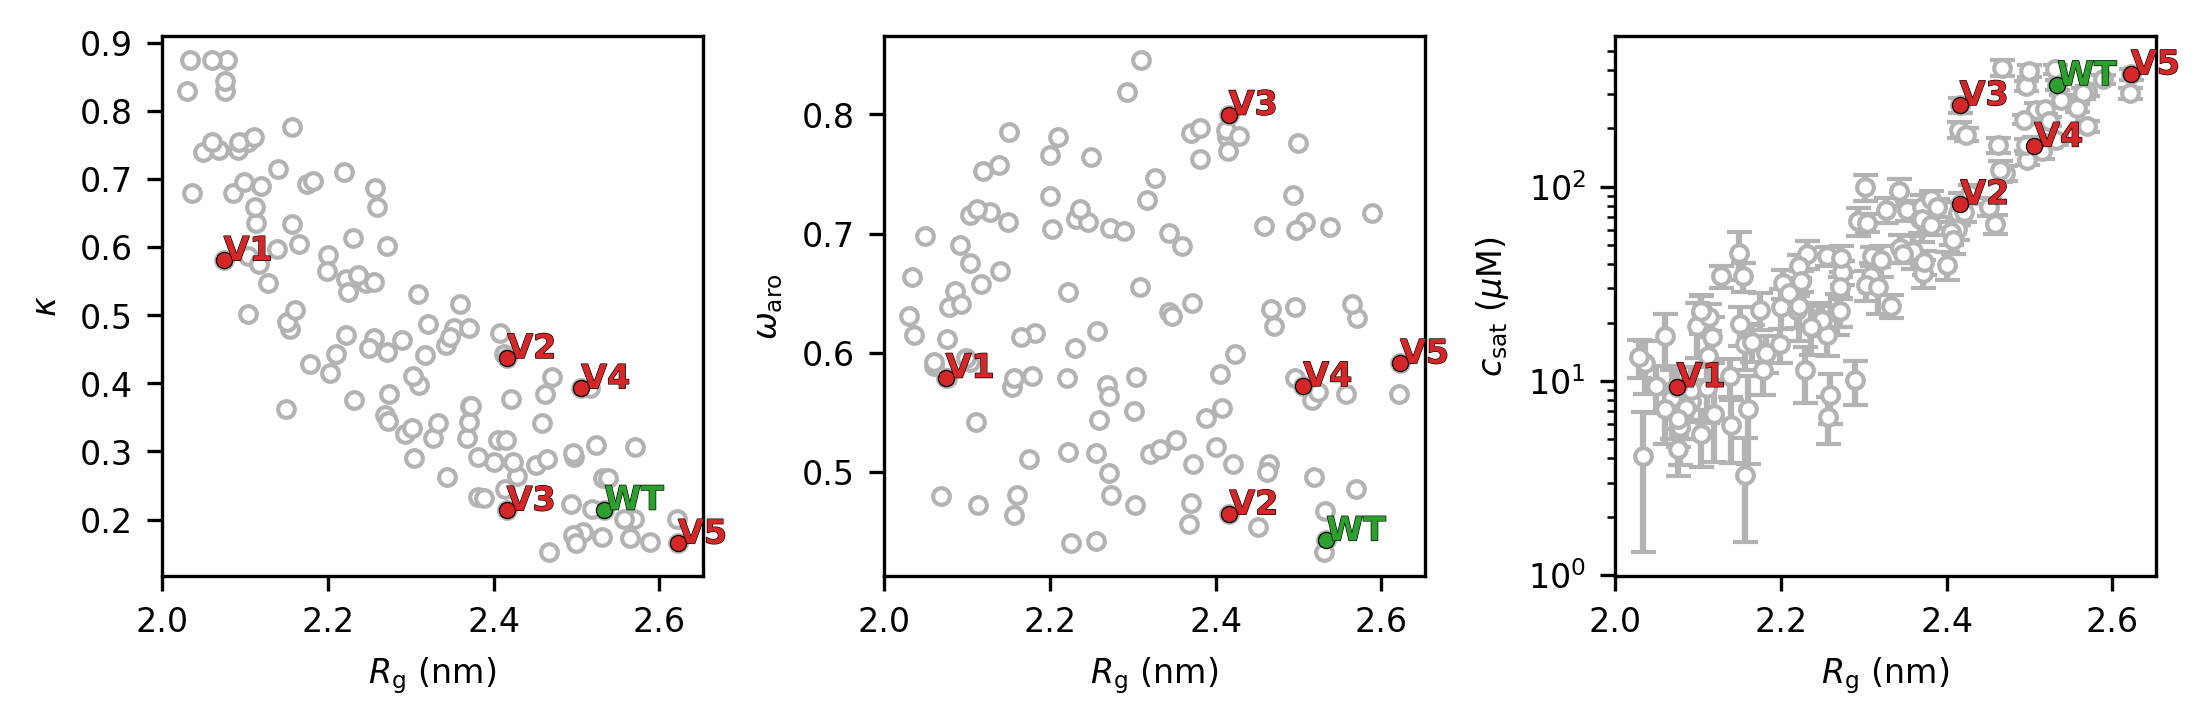

In [80]:
font = {'size': 8}
plt.rc('font', **font)
fig,[ax1,ax2,ax3] = plt.subplots(1,3, figsize=(7.25,3), dpi=300, layout='constrained')

ax1.errorbar(red_df.rg,red_df.kappa, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4)
ax1.set_ylabel(r'$\kappa$')
ax1.set_xlabel(r'$R_{\rm g}$ (nm)')
ax1.set_box_aspect(1)
ax1.scatter(rgexp[0],kappaexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax1.scatter(rgexp[1:],kappaexp[1:],facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])

ax2.errorbar(red_df.rg, red_df.omega_aro, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4)
ax2.set_xlabel(r'$R_{\rm g}$ (nm)')
ax2.set_ylabel(r'$\omega_{\rm aro}$')
ax2.set_box_aspect(1)
ax2.scatter(rgexp[0],oaroexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax2.scatter(rgexp[1:],oaroexp[1:],facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax2.annotate(exp_name[i], (rgexp[i], oaroexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax2.annotate(exp_name[i], (rgexp[i], oaroexp[i]), fontsize=8, zorder=100000000, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
        
_, caps, bars = ax3.errorbar(red_df.rg, red_df.csat_av*1000, yerr=red_df.csat_err*1000, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4, capsize=3)
#[bar.set_alpha(0.7) for bar in bars]
#[cap.set_alpha(0.7) for cap in caps]
ax3.set_box_aspect(1)
ax3.set_yscale('log')
ax3.set_ylabel(r'$c_{\rm sat}$ ($\mu$M)')
ax3.set_xlabel(r'$R_{\rm g}$ (nm)')
ax3.scatter(rgexp[0],csatexp[0]*1000,facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax3.scatter(rgexp[1:],csatexp[1:]*1000,facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax3.annotate(exp_name[i], (rgexp[i], csatexp[i]*1000), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax3.annotate(exp_name[i], (rgexp[i], csatexp[i]*1000), fontsize=8, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])

plt.savefig('fig4.pdf', dpi=300)

### Figure 5

In [85]:
df = pd.DataFrame()
for i in range(10):
    _ = pd.read_pickle('EVOLUTION_DATA/rg_down_A0A1B0GTS1_188_333.pkl'.format(i))
    _['ind'] = ['R'+str(i)+'_g'+str(c) for c in _.index]
    df = pd.concat([df,_])
df = df.set_index('ind')

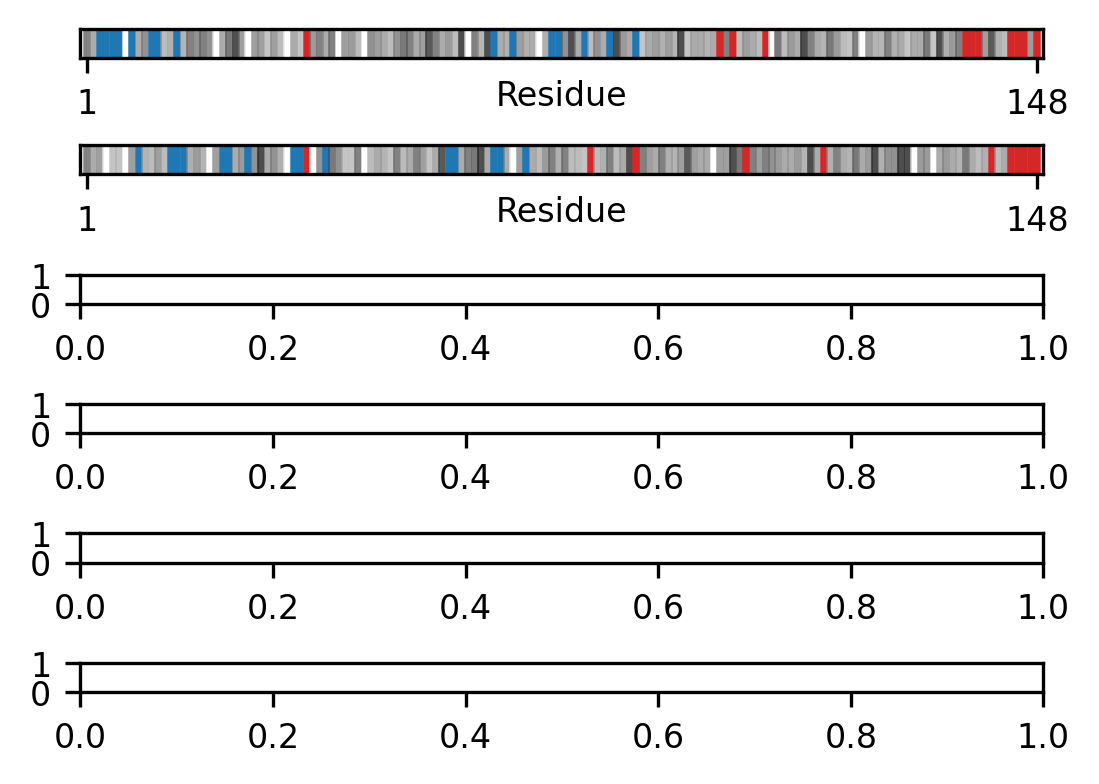

In [90]:
fig,axs = plt.subplots(6,1,figsize=(3.55,2.5), dpi=300, layout='constrained')
axs = axs.flatten()

for ndx,v,ax in zip(['R2_g844','R0_g0'],['V1','V2','V3','V4','V5','WT'],axs):
    seq = 'GS'+''.join(df.loc[ndx].fasta)
    seq_diagram(seq,ax,lw=1.8)
    
plt.savefig('fig5a.pdf', dpi=300)
